In [1]:
%load_ext autoreload
%autoreload 2
from stock_prediction.etl.ticker_data_extractors import train_test_split
from stock_prediction.utils.series import get_normalized_nsteps_ahead_predictions_array
from stock_prediction.evaluation.analysis import summary_analysis
from stock_prediction.helpers.logging.log_config import get_logger
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from stock_prediction.modeling.lightgbm import UnivariateLightGBMs
import pickle
import os

logger = get_logger()

In [2]:
df_train, df_test = train_test_split()

## Rolling Geometric Average baseline & Metrics definition

In [3]:
w_size = 20
# We want to use at least half of the training data to fit
# the model on each TCV step so here we define the range on
# which to predict. Note that we also reject the last w_size
# points because we compute our prediction error on the w_size
# days at each time step
i_predict_min = df_train.shape[0] // 2
i_predict_max = df_train.shape[0] - w_size - 1

In [4]:
df_train_cumulative = (1 + df_train).cumprod()
actuals = get_normalized_nsteps_ahead_predictions_array(
    df=df_train_cumulative,
    n_steps_ahead=w_size,
    index_start=i_predict_min,
    index_end=i_predict_max,
)

# LightGBM regressors

In this notebook we explore using lightgbm regressors per symbol. For this to work we need to prepare features for each symbol together with targets. We will use a model that takes as input:
- The number $n$ of steps ahead to predict (1, 2, 3,..., n_max)
- The values of the series in the last N steps (e.g., 20)
- Rolling window statistics in the last 5, 20, 60, 180 days (average, std, min, max) ==> 16
- fraction of week
- fraction of month
- fraction of year

And the label is the value of the return $n$ steps ahead

If $N$ is 20, we end up with a 1 + 20 + 16 + 3 = 40 features + label and if $n_{max}=20$ we expand the train dataset by a factor of 20.

In [9]:
lgbm_model = UnivariateLightGBMs()
lgbm_model.fit(df_train.iloc[:i_predict_min])

Training BIB...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8243
[LightGBM] [Info] Number of data points in the train set: 15900, number of used features: 40
[LightGBM] [Info] Start training from score 0.002917
Training CSM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8234
[LightGBM] [Info] Number of data points in the train set: 15900, number of used features: 40
[LightGBM] [Info] Start training from score 0.000637
Training CURE...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8257
[LightG

In [14]:
predictions_lgbm = lgbm_model.predict(
    df_train,
    n_steps_predict=w_size,
    index_start=i_predict_min,
    index_end=i_predict_max + 1,
)

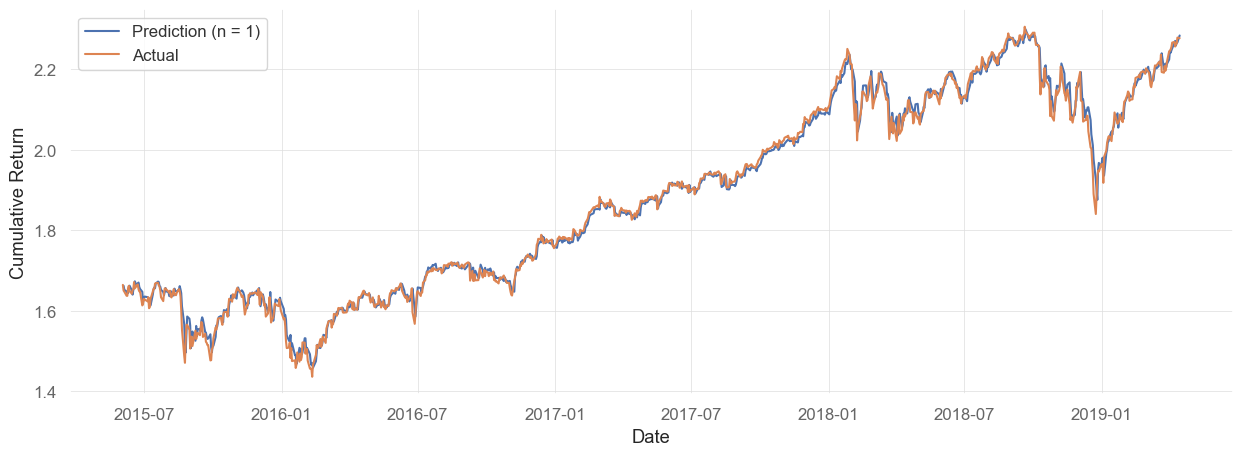

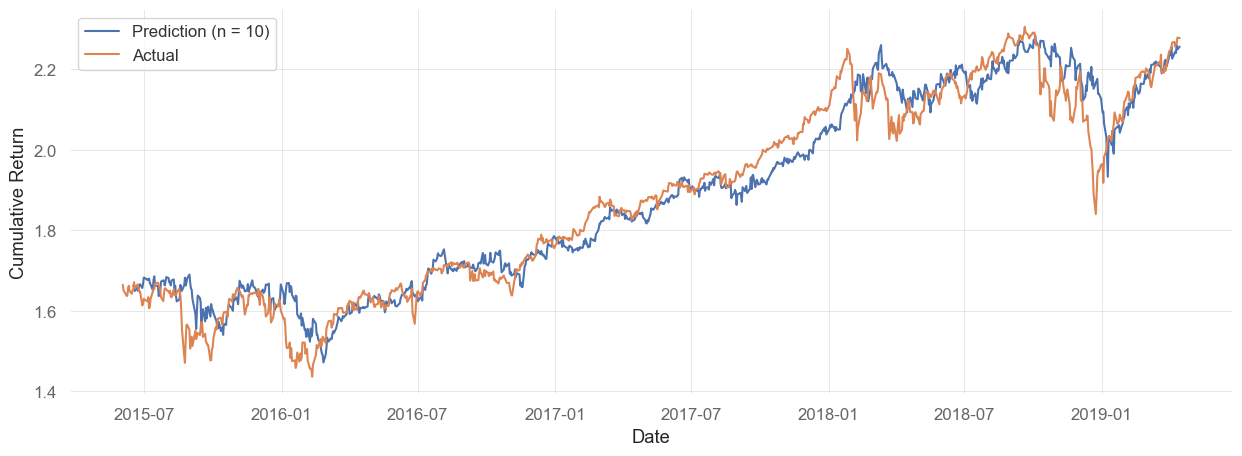

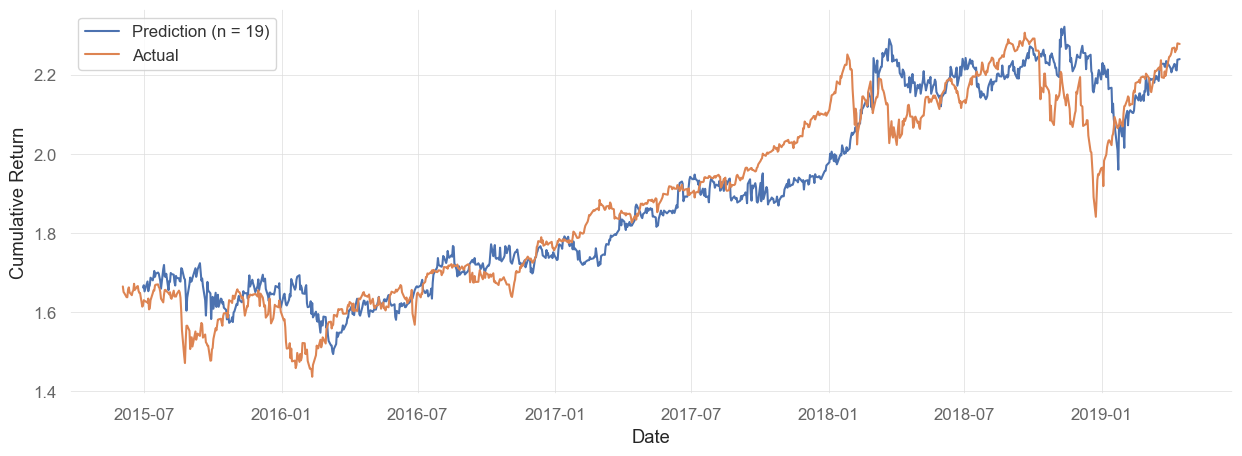

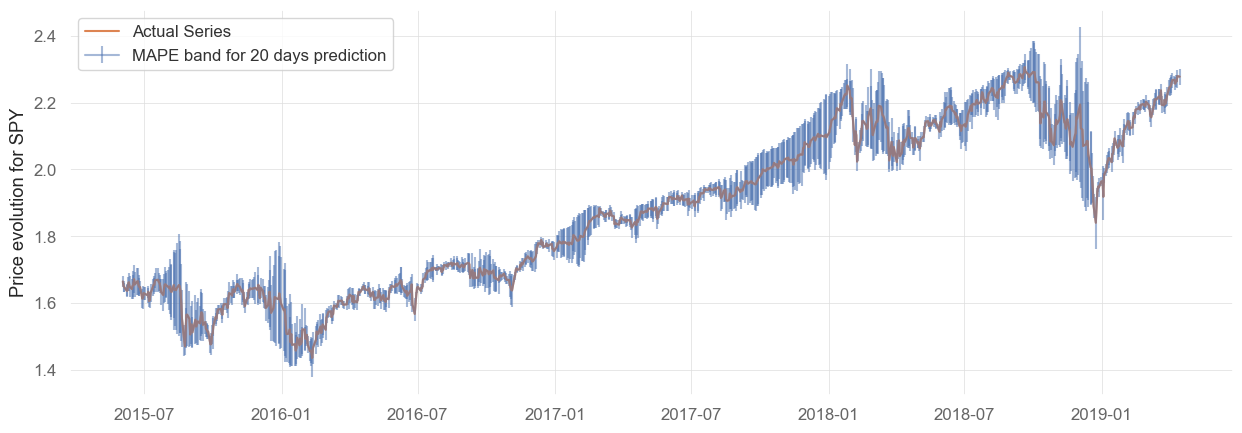

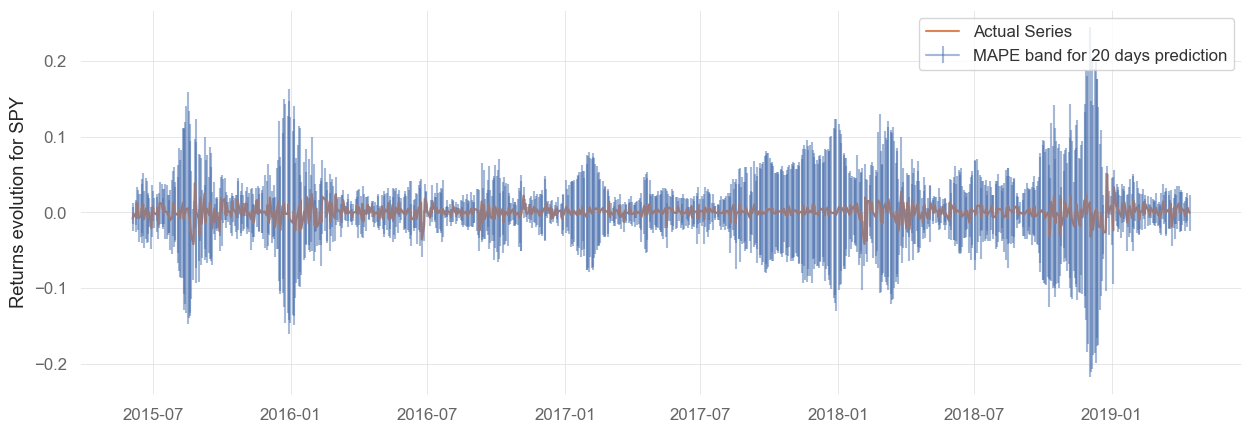

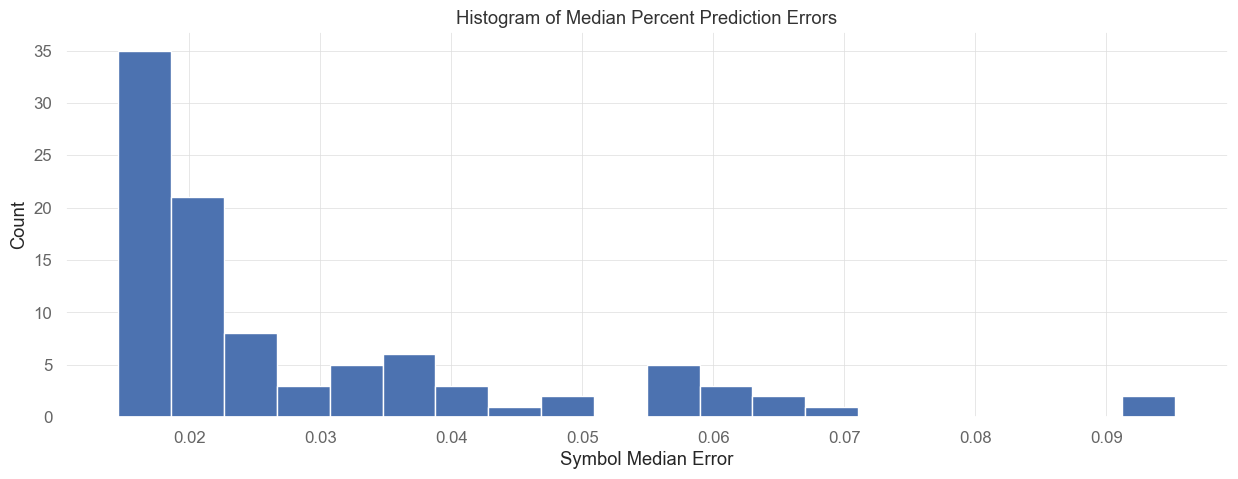

count    97.000000
mean      0.028821
std       0.017237
min       0.014599
25%       0.017481
50%       0.020220
75%       0.035218
max       0.095242
Name: 50%, dtype: float64
Median of Median Errors    0.020220
Mean of Median Errors      0.028821
Mean of Mean Errors        0.037225
dtype: float64


In [16]:
summary_analysis(
    df=df_train,
    n_predict=w_size,
    predictions=predictions_lgbm[:-1, :, :],
    actuals=actuals,
    index_start=i_predict_min,
    index_end=i_predict_max,
    symbol="SPY",
)

In [34]:
from calendar import monthrange
import pandas as pd


def get_time_features(row):
    row_ = row["Date"]
    day = row_.day
    week_day = row_.weekday()
    month = row_.month
    _, ndays_month = monthrange(row_.year, month)

    frac_month = day / ndays_month
    frac_week = (week_day + 1) / 5
    frac_year = (month - 1 + frac_month) / 12
    return pd.Series(
        {"frac_week": frac_week, "frac_month": frac_month, "frac_year": frac_year}
    )


df_time_features = df_train["SPY"].reset_index().apply(get_time_features, axis=1)
df_time_features

,frac_week,frac_month,frac_year
0,1.0,0.566667,0.463889
1,0.2,0.666667,0.472222
2,0.4,0.700000,0.475000
3,0.6,0.733333,0.477778
4,0.8,0.766667,0.480556
...,...,...,...
1985,0.8,0.290323,0.357527
1986,1.0,0.322581,0.360215
1987,0.2,0.419355,0.368280
1988,0.4,0.451613,0.370968


In [35]:
df_time_features.describe()

,frac_week,frac_month,frac_year
count,1990.000000,1990.000000,1990.000000
mean,0.605025,0.516912,0.505471
std,0.280155,0.286885,0.287495
min,0.200000,0.032258,0.005376
25%,0.400000,0.266667,0.255556
50%,0.600000,0.516129,0.513441
75%,0.800000,0.766667,0.755376
max,1.000000,1.000000,1.000000


In [ ]:
def make_shifted_series_df(series, min_shift=0, max_shift=20, shift_name="shifted"):
    return pd.DataFrame(
        {
            f"{shift_name}_{abs(i)}": series.shift(i)
            for i in range(min_shift, max_shift)
        },
        index=series.index,
    )


df_shifted_series = make_shifted_series_df(df_train["SPY"].reset_index(drop=True))
df_shifted_series.head(30)

,shifted_0,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,shifted_9,shifted_10,shifted_11,shifted_12,shifted_13,shifted_14,shifted_15,shifted_16,shifted_17,shifted_18,shifted_19
0,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.011613,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.008911,-0.011613,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.013053,0.008911,-0.011613,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.008564,0.013053,0.008911,-0.011613,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.009562,0.008564,0.013053,0.008911,-0.011613,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_labels = make_shifted_series_df(
    df_train["SPY"].reset_index(drop=True),
    min_shift=-20,
    max_shift=0,
    shift_name="label",
)
df_labels

,label_20,label_19,label_18,label_17,label_16,label_15,label_14,label_13,label_12,label_11,label_10,label_9,label_8,label_7,label_6,label_5,label_4,label_3,label_2,label_1
0,-0.008201,0.005805,-0.006902,0.003349,-0.004319,-0.018080,-0.007092,0.010375,0.001196,-0.000821,0.014776,0.009562,0.008564,0.013053,0.008911,-0.011613,-0.002876,-0.006025,0.013704,0.005116
1,0.016231,-0.008201,0.005805,-0.006902,0.003349,-0.004319,-0.018080,-0.007092,0.010375,0.001196,-0.000821,0.014776,0.009562,0.008564,0.013053,0.008911,-0.011613,-0.002876,-0.006025,0.013704
2,-0.000603,0.016231,-0.008201,0.005805,-0.006902,0.003349,-0.004319,-0.018080,-0.007092,0.010375,0.001196,-0.000821,0.014776,0.009562,0.008564,0.013053,0.008911,-0.011613,-0.002876,-0.006025
3,0.013871,-0.000603,0.016231,-0.008201,0.005805,-0.006902,0.003349,-0.004319,-0.018080,-0.007092,0.010375,0.001196,-0.000821,0.014776,0.009562,0.008564,0.013053,0.008911,-0.011613,-0.002876
4,0.000669,0.013871,-0.000603,0.016231,-0.008201,0.005805,-0.006902,0.003349,-0.004319,-0.018080,-0.007092,0.010375,0.001196,-0.000821,0.014776,0.009562,0.008564,0.013053,0.008911,-0.011613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005857,0.009044,-0.025130,0.005023
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005857,0.009044,-0.025130
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005857,0.009044
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005857


In [38]:
def make_rolling_window_features_df(
    df, windows=[5, 20, 60, 180], stats=["mean", "std", "max", "min"]
):
    series_dict = {}
    for window in windows:
        for stat in stats:
            series_dict[f"{stat}_{window}"] = df.rolling(window=window).agg(stat)

    return pd.DataFrame(series_dict)


df_rolling_features = make_rolling_window_features_df(
    df_train["SPY"].reset_index(drop=True)
)
df_rolling_features

,mean_5,std_5,max_5,min_5,mean_20,std_20,max_20,min_20,mean_60,std_60,max_60,min_60,mean_180,std_180,max_180,min_180
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001591,0.007902,0.013704,-0.006025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,-0.003088,0.009421,0.009788,-0.016700,-0.000268,0.005760,0.009788,-0.01670,0.000765,0.005965,0.014501,-0.019246,0.000075,0.010615,0.050525,-0.032402
1986,-0.004041,0.007913,0.005023,-0.016700,-0.000003,0.005880,0.009788,-0.01670,0.000794,0.005981,0.014501,-0.019246,0.000090,0.010620,0.050525,-0.032402
1987,-0.008244,0.012318,0.005023,-0.025130,-0.001597,0.007919,0.009788,-0.02513,0.000412,0.006846,0.014501,-0.025130,-0.000046,0.010785,0.050525,-0.032402
1988,-0.003096,0.013245,0.009044,-0.025130,-0.001112,0.008269,0.009788,-0.02513,0.000381,0.006802,0.014501,-0.025130,0.000011,0.010806,0.050525,-0.032402


In [39]:
df_processed = pd.concat(
    [df_shifted_series, df_rolling_features, df_time_features], axis=1
)
df_processed

,shifted_0,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,shifted_9,...,std_60,max_60,min_60,mean_180,std_180,max_180,min_180,frac_week,frac_month,frac_year
0,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.566667,0.463889
1,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.666667,0.472222
2,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.700000,0.475000
3,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,0.733333,0.477778
4,-0.002876,-0.006025,0.013704,0.005116,-0.001964,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.766667,0.480556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,-0.003026,-0.001389,-0.016700,-0.004115,0.009788,-0.002159,-0.007516,0.000510,0.001568,0.004657,...,0.005965,0.014501,-0.019246,0.000075,0.010615,0.050525,-0.032402,0.8,0.290323,0.357527
1986,0.005023,-0.003026,-0.001389,-0.016700,-0.004115,0.009788,-0.002159,-0.007516,0.000510,0.001568,...,0.005981,0.014501,-0.019246,0.000090,0.010620,0.050525,-0.032402,1.0,0.322581,0.360215
1987,-0.025130,0.005023,-0.003026,-0.001389,-0.016700,-0.004115,0.009788,-0.002159,-0.007516,0.000510,...,0.006846,0.014501,-0.025130,-0.000046,0.010785,0.050525,-0.032402,0.2,0.419355,0.368280
1988,0.009044,-0.025130,0.005023,-0.003026,-0.001389,-0.016700,-0.004115,0.009788,-0.002159,-0.007516,...,0.006802,0.014501,-0.025130,0.000011,0.010806,0.050525,-0.032402,0.4,0.451613,0.370968


In [40]:
df_processed_list = []
for col in df_labels.columns:
    df_tmp = df_processed.iloc[180:-20].copy()
    df_tmp["n_forecast"] = int(col.split("_")[-1])
    df_tmp["label"] = df_labels[180:-20][col]
    df_processed_list.append(df_tmp)
df_processed_expanded = (
    pd.concat(df_processed_list, axis=0)
    .reset_index()
    .rename(columns={"index": "initial_index"})
)

In [41]:
df_processed_expanded[df_processed_expanded["initial_index"] < i_predict_min]

,initial_index,shifted_0,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,...,min_60,mean_180,std_180,max_180,min_180,frac_week,frac_month,frac_year,n_forecast,label
0,180,-0.014625,-0.004078,-0.003049,0.005182,-0.003926,0.002916,0.001680,0.002196,0.004411,...,-0.021936,0.000458,0.016218,0.046499,-0.065123,0.4,0.193548,0.182796,20,-0.004089
1,181,0.006976,-0.014625,-0.004078,-0.003049,0.005182,-0.003926,0.002916,0.001680,0.002196,...,-0.014625,0.000469,0.016222,0.046499,-0.065123,0.6,0.225806,0.185484,20,-0.009911
2,182,0.009949,0.006976,-0.014625,-0.004078,-0.003049,0.005182,-0.003926,0.002916,0.001680,...,-0.014625,0.000448,0.016207,0.046499,-0.065123,0.8,0.258065,0.188172,20,-0.000501
3,183,0.003868,0.009949,0.006976,-0.014625,-0.004078,-0.003049,0.005182,-0.003926,0.002916,...,-0.014625,0.000503,0.016202,0.046499,-0.065123,1.0,0.290323,0.190860,20,-0.011231
4,184,0.000073,0.003868,0.009949,0.006976,-0.014625,-0.004078,-0.003049,0.005182,-0.003926,...,-0.014625,0.000519,0.016200,0.046499,-0.065123,0.2,0.387097,0.198925,20,-0.016785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34820,990,0.009492,-0.010752,-0.002389,0.002912,-0.000704,-0.000329,0.003107,0.001084,0.010428,...,-0.016222,0.000358,0.008080,0.024729,-0.019833,0.6,0.870968,0.405914,1,-0.001128
34821,991,-0.001128,0.009492,-0.010752,-0.002389,0.002912,-0.000704,-0.000329,0.003107,0.001084,...,-0.016222,0.000387,0.008065,0.024729,-0.019833,0.8,0.903226,0.408602,1,-0.006213
34822,992,-0.006213,-0.001128,0.009492,-0.010752,-0.002389,0.002912,-0.000704,-0.000329,0.003107,...,-0.016222,0.000332,0.008076,0.024729,-0.019833,1.0,0.935484,0.411290,1,0.002037
34823,993,0.002037,-0.006213,-0.001128,0.009492,-0.010752,-0.002389,0.002912,-0.000704,-0.000329,...,-0.016222,0.000337,0.008077,0.024729,-0.019833,0.2,0.033333,0.419444,1,-0.000993


In [42]:
df_processed_expanded.describe()

,initial_index,shifted_0,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,...,min_60,mean_180,std_180,max_180,min_180,frac_week,frac_month,frac_year,n_forecast,label
count,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,...,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000,35800.000000
mean,1074.500000,0.000454,0.000451,0.000450,0.000449,0.000447,0.000447,0.000451,0.000451,0.000451,...,-0.021264,0.000476,0.008149,0.026616,-0.029674,0.604581,0.516053,0.499988,10.500000,0.000442
std,516.735627,0.008185,0.008185,0.008186,0.008185,0.008186,0.008186,0.008185,0.008185,0.008185,...,0.008670,0.000334,0.002236,0.009169,0.009894,0.280230,0.286093,0.285625,5.766362,0.008173
min,180.000000,-0.042107,-0.042107,-0.042107,-0.042107,-0.042107,-0.042107,-0.042107,-0.042107,-0.042107,...,-0.042107,-0.000774,0.004164,0.010666,-0.065123,0.200000,0.032258,0.005376,1.000000,-0.042107
25%,627.000000,-0.003075,-0.003081,-0.003081,-0.003081,-0.003107,-0.003107,-0.003081,-0.003081,-0.003081,...,-0.024941,0.000305,0.006829,0.021558,-0.036910,0.400000,0.266667,0.252778,5.750000,-0.003075
50%,1074.500000,0.000503,0.000499,0.000499,0.000499,0.000499,0.000499,0.000503,0.000503,0.000503,...,-0.019833,0.000525,0.007871,0.024729,-0.025177,0.600000,0.516129,0.497222,10.500000,0.000503
75%,1522.000000,0.004890,0.004890,0.004890,0.004890,0.004890,0.004890,0.004890,0.004890,0.004890,...,-0.015591,0.000706,0.009382,0.027359,-0.022505,0.800000,0.766667,0.747222,15.250000,0.004839
max,1969.000000,0.050525,0.050525,0.050525,0.050525,0.050525,0.050525,0.050525,0.050525,0.050525,...,-0.005005,0.001340,0.016227,0.050525,-0.017744,1.000000,1.000000,1.000000,20.000000,0.050525


In [104]:
lgbm_regressor = LGBMRegressor()  # num_leaves=10, n_estimators=100)
df_train_expanded = df_processed_expanded[
    df_processed_expanded["initial_index"] < i_predict_min
]
lgbm_regressor.fit(
    df_train_expanded.drop(["initial_index", "label"], axis=1),
    df_train_expanded["label"],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8237
[LightGBM] [Info] Number of data points in the train set: 16300, number of used features: 40
[LightGBM] [Info] Start training from score 0.000530


LGBMRegressor()

In [105]:
lgbm_regressor.feature_importances_
# get feature column names ordered by descending feature importance
feature_names = df_processed_expanded.drop(["initial_index", "label"], axis=1).columns[
    (-lgbm_regressor.feature_importances_).argsort()
]
feature_names

Index(['n_forecast', 'std_180', 'frac_month', 'frac_year', 'std_60', 'mean_60',
       'min_5', 'mean_180', 'mean_20', 'min_20', 'std_20', 'max_20', 'std_5',
       'mean_5', 'max_5', 'max_60', 'shifted_15', 'min_60', 'shifted_9',
       'shifted_14', 'shifted_0', 'shifted_17', 'shifted_13', 'shifted_10',
       'shifted_11', 'shifted_4', 'shifted_7', 'max_180', 'shifted_18',
       'shifted_2', 'shifted_12', 'shifted_16', 'shifted_19', 'shifted_5',
       'shifted_6', 'shifted_3', 'shifted_8', 'shifted_1', 'min_180',
       'frac_week'],
      dtype='object')

In [106]:
# get feature importance for each feature after sorting
sorted_feature_importances = lgbm_regressor.feature_importances_[
    (-lgbm_regressor.feature_importances_).argsort()
]
normalized_feature_importances = (
    sorted_feature_importances / sorted_feature_importances.sum()
)
cumsum_feature_importances = normalized_feature_importances.cumsum()
df_feature_importances = pd.DataFrame(
    {
        "feature": feature_names,
        "normalized_importance": normalized_feature_importances,
        "cumsum": cumsum_feature_importances,
    }
)
df_feature_importances

,feature,normalized_importance,cumsum
0,n_forecast,0.238333,0.238333
1,std_180,0.046333,0.284667
2,frac_month,0.045667,0.330333
3,frac_year,0.042667,0.373000
4,std_60,0.039667,0.412667
5,mean_60,0.038333,0.451000
6,min_5,0.035000,0.486000
7,mean_180,0.032333,0.518333
8,mean_20,0.031333,0.549667
9,min_20,0.028333,0.578000


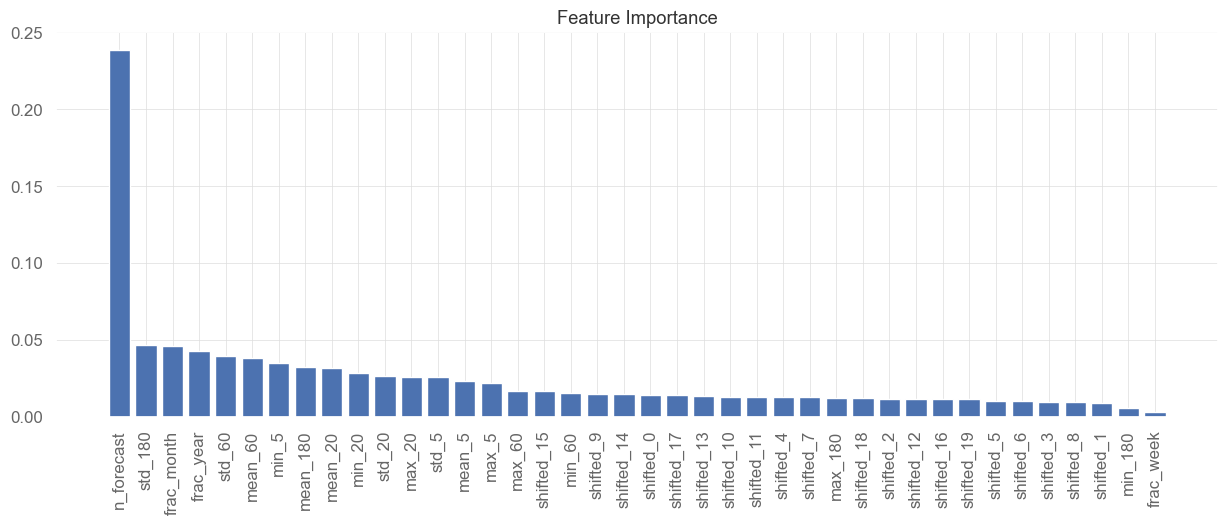

In [107]:
plt.figure(figsize=(15, 5))
plt.bar(
    df_feature_importances["feature"], df_feature_importances["normalized_importance"]
)
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

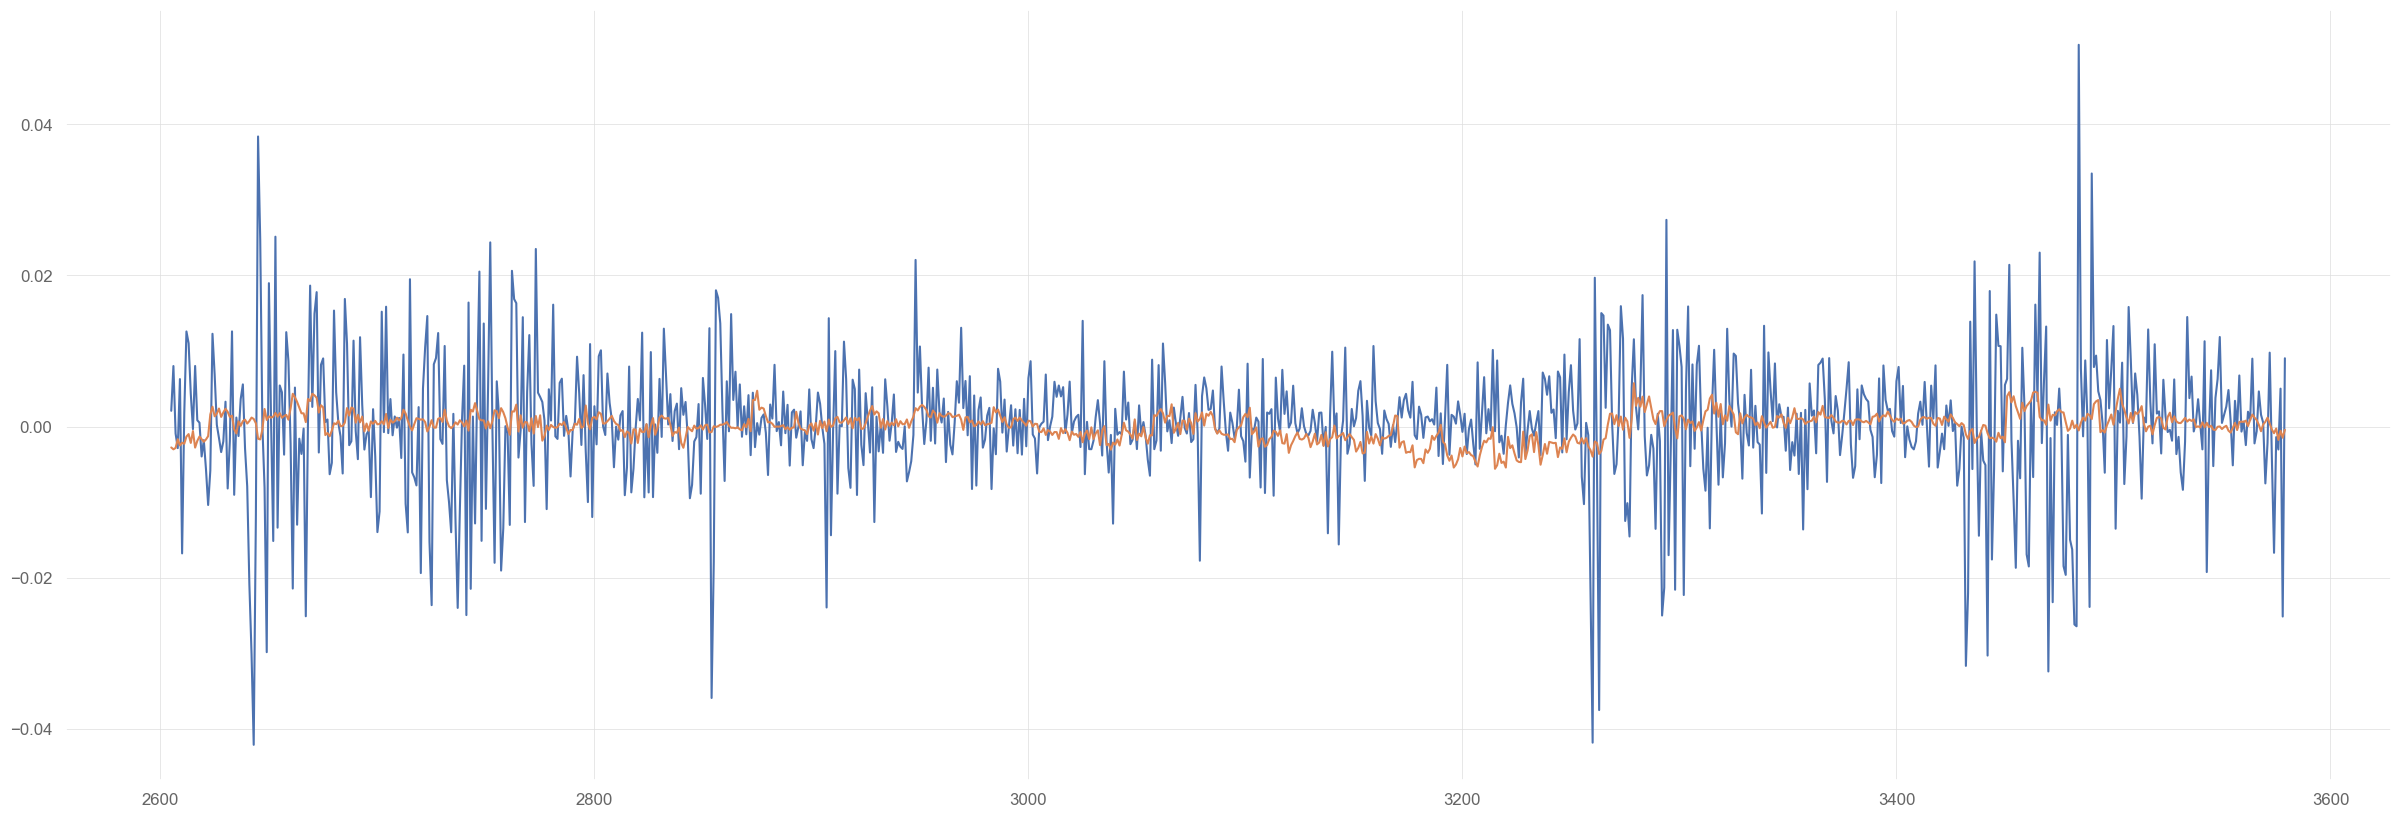

In [110]:
df_test_lgbm = df_processed_expanded[
    df_processed_expanded["initial_index"] >= i_predict_min
]
predicts_lgbm = lgbm_regressor.predict(
    df_test_lgbm.drop(["initial_index", "label"], axis=1)
)
df_preds = df_test_lgbm[["initial_index", "n_forecast", "label"]].copy()
df_preds["predict"] = predicts_lgbm

plt.figure(figsize=(30, 10))
plt.plot(df_preds[df_preds["n_forecast"] == 19]["label"])
plt.plot(df_preds[df_preds["n_forecast"] == 19]["predict"])
plt.show()

In [109]:
df_preds.groupby("n_forecast").apply(
    lambda x: x[["label", "predict"]].corr().iloc[0, 1]
)

/tmp/ipykernel_97469/3695994076.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_preds.groupby("n_forecast").apply(lambda x: x[["label", "predict"]].corr().iloc[0, 1])


n_forecast
1     0.008092
2     0.052219
3     0.023493
4     0.033778
5     0.012444
6     0.041983
7     0.016469
8    -0.013888
9    -0.041178
10   -0.024896
11   -0.008354
12   -0.004719
13   -0.003602
14   -0.002020
15    0.011701
16    0.004796
17    0.035287
18    0.008713
19    0.024101
20    0.004160
dtype: float64

In [122]:
df_preds.groupby("initial_index")[["initial_index", "n_forecast", "predict"]].apply(
    lambda x: pd.Series(x.sort_values(by="n_forecast")["predict"].values)
).sort_index().to_numpy()

array([[-2.14820677e-03, -1.44124731e-03, -1.36343888e-03, ...,
        -2.75969413e-03, -2.75969413e-03, -2.75969413e-03],
       [-9.52201736e-05,  2.05060602e-04, -3.39040377e-04, ...,
        -3.00626472e-03, -3.00626472e-03, -2.71273570e-03],
       [-5.48797799e-04, -1.08982727e-03, -9.82189316e-04, ...,
        -2.82523987e-03, -2.82523987e-03, -3.38617684e-03],
       ...,
       [ 1.17771561e-03,  6.68847165e-04,  1.44498188e-04, ...,
        -6.12915848e-04, -5.49145810e-04, -5.99857094e-04],
       [ 1.26294251e-03,  7.66038215e-04, -3.74121043e-05, ...,
        -1.04850803e-03, -1.47130970e-03, -2.13617459e-03],
       [-3.35603386e-04, -1.80203915e-04, -3.00008709e-04, ...,
        -4.23048070e-04, -4.23048070e-04, -6.43937942e-04]])

In [116]:
df_preds

,initial_index,n_forecast,label,predict
815,995,20,0.008016,-0.002760
816,996,20,-0.000916,-0.002713
817,997,20,-0.002846,-0.003386
818,998,20,0.006289,-0.001590
819,999,20,-0.016777,-0.002686
...,...,...,...,...
35795,1965,1,-0.000278,0.001647
35796,1966,1,0.006766,0.000490
35797,1967,1,-0.000655,0.001178
35798,1968,1,0.000655,0.001263


## Univariate ARIMA Models

In this section, we explore univariate ARIMA models which can use moving average and autoregressive terms in a more principled way. Our previous pacf and acf analysis suggests p and q could go up to about 25. We will fit one ARIMA model per symbol and will analyze the n steps ahead forecasts as before. 

First we will try to understand if differencing seems necessary.

Text(0.5, 1.0, '60-Day Rolling Mean and Standard Deviation')

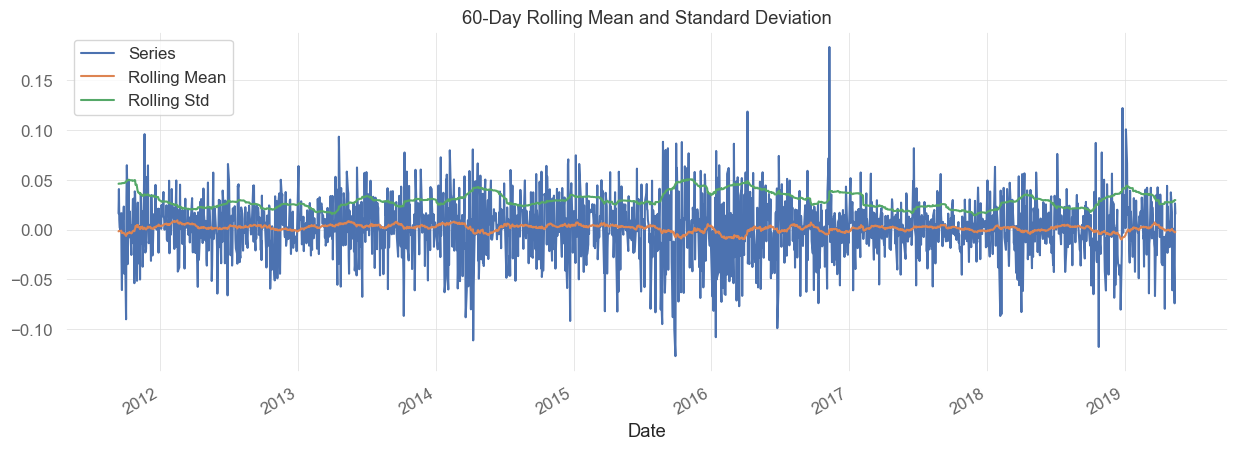

In [5]:
# In this example we can see that though the rolling average is small it is not very
# constant so differencing is a good idea.
series = df_train.iloc[:, 0]
window = 60
plt.figure(figsize=(15, 5))
series[window:].plot()
series_rolling = series.rolling(window=window)
series_rolling.mean()[window:].plot()
series_rolling.std()[window:].plot()
plt.legend(["Series", "Rolling Mean", "Rolling Std"])
plt.title(f"{window}-Day Rolling Mean and Standard Deviation")

Text(0.5, 1.0, '60-Day Rolling Mean and Standard Deviation')

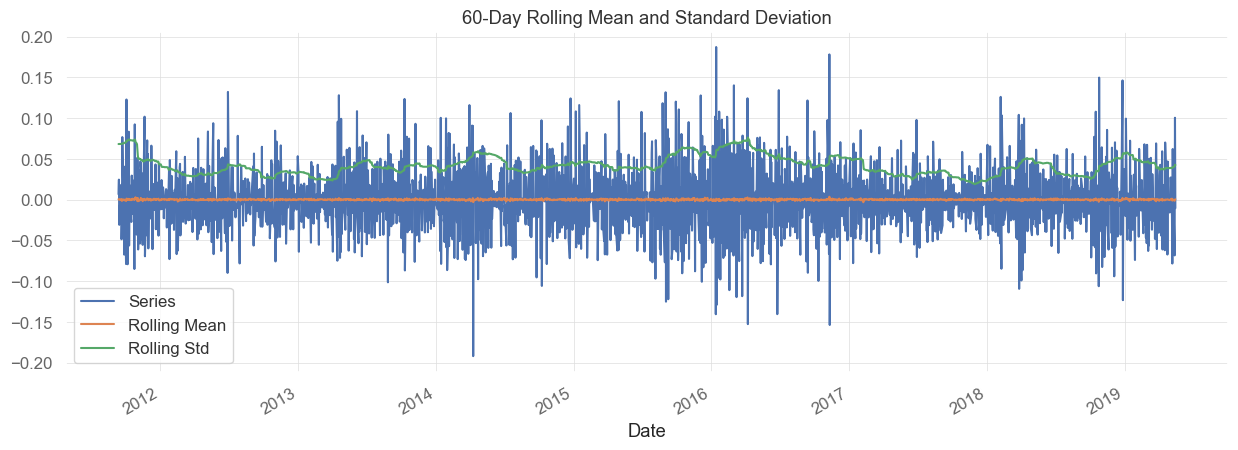

In [6]:
# Applying a first order differencing we see that the rolling average
# is much more constant and close to zero
series = df_train.iloc[:, 0].diff()
window = 60
plt.figure(figsize=(15, 5))
series[window:].plot()
series_rolling = series.rolling(window=window)
series_rolling.mean()[window:].plot()
series_rolling.std()[window:].plot()
plt.legend(["Series", "Rolling Mean", "Rolling Std"])
plt.title(f"{window}-Day Rolling Mean and Standard Deviation")

In [7]:
orders = [
    (2, 1, 0),
    (2, 1, 1),
    (2, 1, 2),
    (5, 1, 0),
    (5, 1, 2),
    (5, 1, 5),
    (10, 1, 0),
    (10, 1, 5),
    (10, 1, 10),
    (20, 1, 0),
    (20, 1, 10),
    (20, 1, 20),
]

In [ ]:
for order in orders:
    predictions_checkpoint_name = (
        f"predictions_arima_{order[0]}_{order[1]}_{order[2]}.pkl"
    )

    if predictions_checkpoint_name in os.listdir():
        predictions_arima = pickle.load(open(predictions_checkpoint_name, "rb"))
    else:
        arima_model = UnivariateARIMA(p=order[0], d=order[1], q=order[2])
        arima_model.fit(df_train.iloc[:i_predict_min, :])
        predictions_arima = arima_model.predict(
            df_train,
            index_start=i_predict_min,
            index_end=i_predict_max,
            n_steps_predict=w_size,
        )
        pickle.dump(predictions_arima, open(predictions_checkpoint_name, "wb"))
    summary_analysis(
        df=df_train,
        n_predict=w_size,
        predictions=predictions_arima,
        actuals=actuals,
        index_start=i_predict_min,
        index_end=i_predict_max,
        symbol="SPY",
    )

/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
